In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import operator
import math
import random
!pip install numpy
import numpy
!pip install deap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

(21,) (21,)


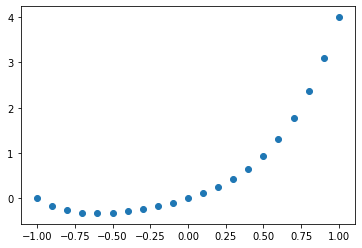

In [2]:
X = numpy.arange(-1,1.1,step=0.1)
Y = numpy.array([0.0000, -0.1629, -0.2624, -0.3129, -0.3264, -0.3125, -0.2784, -0.2289, -0.1664, -0.0909, 0.0, 0.1111, 0.2496 , 0.4251, 0.6496 ,0.9375, 1.3056, 1.7731, 2.3616 ,3.0951 ,4.0000])
print(X.shape, Y.shape)
plt.scatter(X,Y)
plt.show()

pop_size = 1000
K = 3  # tournament size
n_generations = 50
p_c = 0.7
p_m = 0.

In [3]:
# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    abs_errors = [numpy.abs(func(x) - Y[i]) for i,x in enumerate(points)]
    return math.fsum(abs_errors),

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=K)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

def main():
    random.seed(318)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop, toolbox, p_c, p_m, n_generations, stats=mstats,
                                   halloffame=hof, verbose=True)
    # print log
    return pop, log, hof

pop, log, hof = main()
print(hof)


   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	max    	nevals	gen	max	nevals
0  	1000  	0  	306.506	1000  	0  	7  	1000  
1  	726   	1  	71.6294	726   	1  	9  	726   
2  	662   	2  	52.4096	662   	2  	9  	662   
3  	696   	3  	29.9689	696   	3  	9  	696   
4  	720   	4  	32.3421	720   	4  	8  	720   
5  	714   	5  	28.0409	714   	5  	10 	714   
6  	666   	6  	25.9063	666   	6  	9  	666   
7  	716   	7  	27.2572	716   	7  	10 	716   
8  	710   	8  	27.2572	710   	8  	10 	710   
9  	648   	9  	29.7666	648   	9  	10 	648   
10 	720   	10 	34.9334	720   	10 	11 	720   
11 	656   	11 	47.7666	656   	11 	11 	656   
12 	684   	12 	41.2696	684   	12 	12 	684   
13 	716   	13 	53.9334	716   	13 	12 	716   
14 	694   	14 	47.7666	694   	14 	13 	694   
15 	734   	15 	47.7666	734   	15 	13 	734   
16 	688   	16 	47.7666	688   	16 	15 	688   
17 	698   	17 	40.6334	698   	17 	17 	698   
18 	672   	18 	69.2334	672   	1

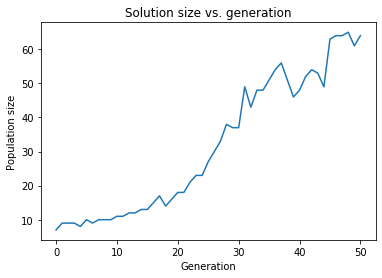

In [4]:
max_s = log.chapters['size'].select("max")
plt.figure()
plt.plot(numpy.arange(51), max_s)
plt.title('Solution size vs. generation')
plt.xlabel('Generation')
plt.ylabel('Population size')
#plt.savefig('A1_8a1')
plt.show()


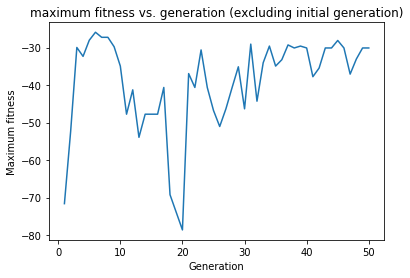

In [8]:
gen, max_g = log.chapters['fitness'].select("gen", "max")
plt.figure()
plt.plot(gen[1:], -numpy.array(max_g)[1:])
plt.title('maximum fitness vs. generation (excluding initial generation)')
plt.xlabel('Generation')
plt.ylabel('Maximum fitness')
#plt.savefig('A1_8a2')
plt.show()

mul(add(mul(mul(x, x), x), x), sub(x, -1))


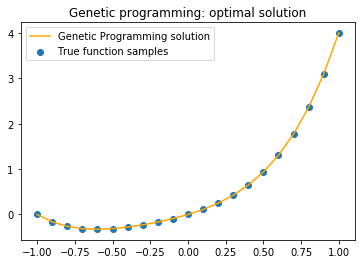

In [6]:
print(hof[0])
plt.figure()
plt.scatter(X,Y, label='True function samples')
plt.plot(X, X**4+X**3+X**2+X, label='Genetic Programming solution',color='orange')
plt.title('Genetic programming: optimal solution')
plt.legend(loc='best')
#plt.savefig('A1_8a3')
plt.show()